# Übung 4.1 : Das Traglinienverfahren und die Prandtl'sche Tragflügeltheorie - Trapezflügel

<div style="text-align: justify"> </p>Die Übung 4 ist die erste von insgesamt fünf computer-basierten Übungen und soll einen ersten Einblick in aerodynamische Optimierungsaufgaben geben und wie sie mit Algorithmen gelöst werden können. </p>

Die **Prandtl'sche Traglinientheorie (engl. "lifting line theory")** besteht seit der Zeit des ersten Weltkrieges und findet heutzutage immernoch Anwendung. Darauf basierend wird das numerische Traglinienverfahren als analytische Methode eingesetzt, um im Flügel-Vorentwurf Vorhersagen über Effizienz und Verluste von Tragflügeln endlicher Streckung zu treffen.

Was liefert die Traglinientheorie?
- Auftriebsverteilung entlang der Spannweite
- Auftriebskraft 
- Induzierter Widerstand (Effizienz)

Was sind die Einschränkungen?
- gilt nur für große Streckungen
- Pfeilung kann nicht berücksichtigt werden 
- gilt nur für kleine Anstellwinkel

Die ausführliche Theorie zum Verfahren findet ihr in den Skripten begleitend zur Vorlesung. Nachfolgend soll nun exemplarisch gezeigt werden, wie ein solches Traglinienverfahren grundlegend in Python implementiert werden kann. Anschließend werden die Aufgaben aus der Übung gelöst. Das orangene Symbol 🟠 kennzeichnet Bereiche, in denen Parameter geändert werden können bzw. sollen. Dies beinhaltet vor allem Geometrie- und Randparameter der Rechnung.
 </div>

In [228]:
# Importieren von Python-Biblioteken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, IntSlider, FloatSlider, fixed, VBox, HBox, Label
import ipywidgets as widgets

# Erhöhen der Plot-Auflösung
plt.rcParams["figure.dpi"] = 140

### 4.1.1 Visualisierung: Trapezflügel

In [229]:
def trapezfluegel(l_a, AR, l_i=1.0) -> np.array:
    """Generiert die Planform eines Doppeltrapezflügels auf Basis der gegebenen Flügeltiefen und Streckung"""

    # Berechnung der Halbspannweite
    b = (l_a + l_i) * AR / 2
    s = b / 2

    # Definition aller Eckpunkte
    points = np.array([
        [0, 0], [s, -l_a/2 + l_i/2], [s, l_a/2 + l_i/2], [0, l_i], 
        [-s, l_a/2 + l_i/2], [-s, -l_a/2  + l_i/2], [0, 0]
    ])
    
    return points

def plot_trapezfluegel(l_a, AR):
    """Plottet die Planform eines Doppeltrapezflügels auf Basis der gegebenen Flügeltiefen und Streckung"""
    
    # Flügeleckpunkte generieren
    points = trapezfluegel(l_a, AR)

    # Geometrie plotten
    plt.figure(figsize=(7, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Doppeltrapezflügel')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()

def widget_trapezfluegel():
    """Erzeugt ein widget, mit dem sich die Planform eines Doppeltrapezflügels interaktiv visualisieren lässt"""

    slider_l_a = VBox([Label('Flügeltiefe außen'), FloatSlider(value=0.5, min=0, max=1.0, step=0.1)])
    slider_AR = VBox([Label('Streckung'), FloatSlider(value=10, min=5, max=20, step=1)])

    # Interaktiver plot
    ui = VBox([slider_l_a, slider_AR])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_trapezfluegel, {'l_a': slider_l_a.children[1], 'AR': slider_AR.children[1]})

    return HBox([out, ui])

In [230]:
display(widget_trapezfluegel())

### 4.1.2 Geometrische Parameter und Randbedinungen

In [231]:
# Konstant
alpha = 5                       # Anstellwinel [deg]
alpha = alpha / 180 * np.pi     # Anstellwinel [rad]  
U_inf = 10.0                    # Anströmgeschwindigkeit [m/s]
rho = 1.225                     # Dichte [kg/m^3]
l_i = 1.0                       # Flügeltiefe Wurzel [m]

#### 🟠

In [232]:
# Diese Parameter können verändert werden

l_a = 1                         # Flügeltiefe außen [m]
AR = 10                         # Streckung/ Aspect Ratio

#### Berechnung weiterer geometrischer Parameter

In [233]:
# Berechnung der Halbspannweite
b = (l_i + l_a) * AR / 2
s = b / 2 

# Berechnung der Flügelfläche aus Halbspannweite und Streckung
S = b/2 * (l_a + l_i)       

print("Spannweite:                  ", "%.2f" % b, "m")
print("Halbspannweite:              ", "%.2f" % s, "m")
print("Flügelfläche:                ", "%.2f" % S, "m^2")

Spannweite:                   10.00 m
Halbspannweite:               5.00 m
Flügelfläche:                 10.00 m^2


### 4.1.3 Visualisierung der Diskretisierung

In [234]:
def tiefe_trapez(y, l_a, s) -> float:
    """Berechnet mit gegebenen Geometriepartametern eines Doppeltrapezflügels die lokale Flügeltiefe für eine spannweitige Position"""
    return 1 + (l_a - 1) * (abs(y) / s)
    
def plot_diskretisierung_trapez(l_a, AR, s, N):
    """Plottet die Diskretisierung eines Doppeltrapezflügels auf Basis der Anzahl der Elementarflügel"""
    points = trapezfluegel(l_a, AR)
    
    # Diskretisierung der Halbspannweite
    y_values = np.linspace(-s, s, N+1)
    chord_values = [tiefe_trapez(y, l_a, s) for y in y_values]
    
    # Geometrie plotten
    plt.figure(figsize=(6, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")

    # Elementarflügel plotten
    for i in range(N):
        plt.plot([y_values[i], y_values[i]], [-chord_values[i]/2 + l_i/2, chord_values[i]/2 + l_i/2], 'g-')
    
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Diskretisierung Trapezflügel')
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

def widget_diskretisierung_trapez(l_a, AR, s):
    """Erzeugt ein widget, mit dem sich die Diskretisierung eines Doppeltrapezflügels interaktiv visualisieren lässt"""

    slider_N = VBox([Label('Anzahl der Elementarflügel'), IntSlider(value=30, min=1, max=100, step=1)])

    # Interaktiver plot
    ui = VBox([slider_N])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_diskretisierung_trapez, {'l_a': fixed(l_a), 'AR': fixed(AR), "s": fixed(s), 'N': slider_N.children[1]})
    return HBox([out, ui])

In [235]:
display(widget_diskretisierung_trapez(l_a, AR, s))

### 4.1.4 Berechnung der Hufeisenwirbel-Koordinaten
Zur Bestimmung der $N$ (Variable n) unbekannten Wirbelstärken $\Gamma$ wird die kinematische Strömungsbedingung in den $N$ (Variable $m$) Aufpunkten erfüllt, und man hat ein lineares Gleichungssystem zu lösen. Dafür werden die Koordinaten des tragenden Wirbels entlang der örtlichen $l_p/4$-Linie (indizes a, b) am Rand jedes Elementarflügels sowie die der Aufpunkte im $3l_p/4$–Punkt des Mittelschnittes jedes Elementarflügels (index c) bestimmt. Der Koordinatenursprung (x, y) = (0, 0) liegt hierbei dort, wo sich die Symmetrieachse des Flügels (Rumpf) und die Vorderkante.

#### 🟠

In [236]:
# Diese Parameter können verändert werden
N = 500                             # Anzahl der Elementarflügel

In [237]:
# Breite eines Elementarflügels
delta_b = b/N    

def x_position(y, l_i, l_a, s, aufpunkt=False):
    """Berechnet die Tiefenposition der Punkte A und B und des Aufpunkts C"""

    tiefe = 0.75 if aufpunkt else 0.25
    return abs(y) / s * (l_i - l_a) / 2 + tiefe * (l_i - abs(y) / s * (l_i - l_a))


def compute_coords(s, N, delta_b, l_i, l_a):
    """Berechnet die Hufeisenwirbel-Koordinaten aus Basis der Flügelgeometrie und Anzahl der Elementarflügel"""

    # Spannweitige Positionen der Punkte A, B und Aufpunkt C
    y_a = np.array([-s +  j    * delta_b for j in range(N)])
    y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
    y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])
        
    x_a = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_a])
    x_b = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_b])
    x_c = np.array([x_position(y_i, l_i, l_a, s, True) for y_i in y_c])

    # Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
    y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
    y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

    # Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
    x_aoo = x_a + 100*s
    x_boo = x_b + 100*s

    return y_a, y_b, y_c, x_a, x_b, x_c, y_aoo, y_boo, x_aoo, x_boo

# Berechnen aller Hufeisenwirbel-Koordinaten
y_a, y_b, y_c, x_a, x_b, x_c, y_aoo, y_boo, x_aoo, x_boo = compute_coords(s, N, delta_b, l_i, l_a)

### 4.1.5 Berechnung der Koeffizientenmatrix

Die Koeffizientenmatrix `a` ist die Summe der gebundenen und freien Wirbel.
Die Koeffizientenmatrix der induzierenden Wirbel `a_ind` ist die Summe der freien Wirbel.
Die Wirbelstärken `Gamma` werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet.

In [238]:
def compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c):
    """Berechnet die drei Anteile der Koeffizientenmatrix"""
    # Initialisieren der Matrizen
    a_AB = np.zeros((x_a.size, x_a.size))
    a_Aoo = np.zeros((x_a.size, x_a.size))
    a_Boo = np.zeros((x_a.size, x_a.size))

    # Berechnen der Anteile der gebundenen Wirbel
    for j in range(N):
        for i in range(N):
            a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

    # Berechnen der Anteile der freien Wirbel der linken Seite
    for j in range(N):
        for i in range(N):
            a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

    # Berechnen der Anteile der freien Wirbel der rechten Seite
    for j in range(N):
        for i in range(N):
            a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)
    
    return a_AB, a_Aoo, a_Boo

In [239]:
# Berechnen der Anteile der Koeffizientenmatrix
a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c)

a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

# Löst das lineare Gleichungssystem Ax = b, wobei
# A - Koeffizientenmatrix a
# x - Zirkulationsvektor Gamma
# B - Koeffizientenvektor alpha_g * (- U_inf)
Gamma = np.linalg.solve(a, alpha_g * (- U_inf)) 

### 4.1.6 Berechnung von Kräften und Beiwerten
#### Auftrieb und Widerstand

In [240]:
# Berechnung des Auftriebs nach Kutta-Joukowsky
A_j = rho * delta_b * U_inf * Gamma
A = np.sum(A_j)

# Berechnung des induzierten Widerstands
w_m = a_ind @ Gamma
W_ind = np.sum(-rho *w_m @ Gamma * delta_b)

print("Auftrieb:                    ", "%.2f" % A, "N")
print("Induzierter Widerstand:      ", "%.2f" % W_ind, "N")

Auftrieb:                     257.76 N
Induzierter Widerstand:       5.04 N


#### Auftriebsverteilung

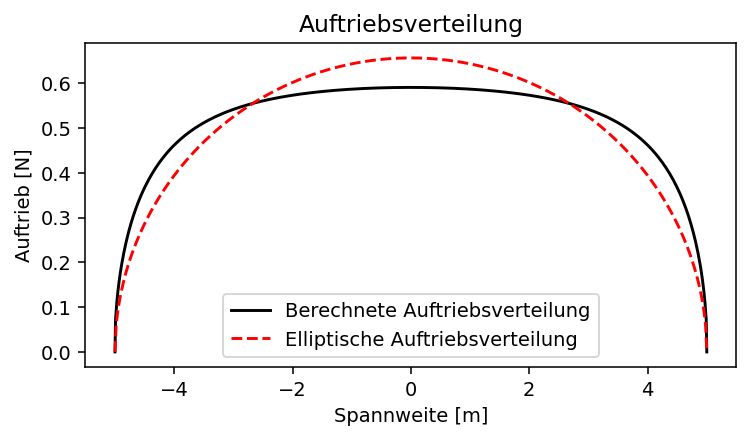

In [241]:
# Hinzufügen von Endpunkten zum plotten
A_j = np.insert(A_j, 0, 0)
A_j = np.append(A_j, 0)
y_c = np.insert(y_c, 0, -s)
y_c = np.append(y_c, s)

# Berechnen der Fläche unter der berechneten Auftriebsverteilung
area_distr = np.trapz(A_j, y_c)

# Erzeugen einer elliptischen Auftriebsverteilung
y_elliptisch = np.linspace(-s, s, len(y_c))
A_elliptisch_raw = np.sqrt(1 - (y_elliptisch / s) ** 2)

# Skalieren der elliptischen Verteilung, sodass die resultierende Auftriebskraft identisch ist
area_elliptisch_raw = np.trapz(A_elliptisch_raw, y_elliptisch)
scale_factor = area_distr / area_elliptisch_raw
A_elliptisch = A_elliptisch_raw * scale_factor

# Plotten der Auftriebsverteilungen
plt.figure(figsize=(6, 3))
plt.plot(y_c, A_j, '-', color="black", label='Berechnete Auftriebsverteilung')
plt.plot(y_elliptisch, A_elliptisch, '--', color="red", label='Elliptische Auftriebsverteilung')
plt.xlabel('Spannweite [m]')
plt.ylabel('Auftrieb [N]')
plt.title('Auftriebsverteilung')
plt.legend()
plt.show()

#### Aerodynamische Beiwerte und Oswald Faktor

In [242]:
# Auftriebsbeiwert
C_A = 2*A / rho / U_inf**2 / S

# Widerstandsbeiwert (induziert)
C_W_ind = 2*W_ind / rho / U_inf**2 / S

# Induzierter Widerstand der elliptischen Zirkulationsverteilung
C_W_ind_ell = C_A**2 / AR / np.pi

# Oswald Faktor
Oswald = C_W_ind_ell / C_W_ind

print("Auftriebsbeiwert:            ", "%.5f" % C_A)
print("Widerstandsbeiwert:          ", "%.5f" % C_W_ind)
print("Widerstandsbeiwert (Ellipse):", "%.5f" % C_W_ind_ell)
print("Oswald-Faktor:               ", "%.2f" % Oswald)

Auftriebsbeiwert:             0.42083
Widerstandsbeiwert:           0.00823
Widerstandsbeiwert (Ellipse): 0.00564
Oswald-Faktor:                0.68


## Aufgabe 1 a) Konvergenzstudie

Untersuchen Sie am Beispiel des Rechteckflügels mit $l_i=1$ und $\Lambda = 10$ das Konvergenzverhalten der aerodynamischen Beiwerte ($C_W$, $C_A$) und des Oswald Faktors hinsichtlich der Abhängigkeit von der Anzahl der Elementarflügel (räumliche Diskretisierung).
Entscheiden Sie sich für eine Diskretisierung für alle folgenden Aufgabenteile und begründen Sie diese Entscheidung.

#### Iterationsschleife

In [243]:
# Initialisieren der benötigten Variablen
N_study = [10, 15, 25, 50, 100, 200, 500, 750, 1000]
C_A, C_W_ind, Oswald = [], [], []

# Iteration über verschiedene N
for c, N in enumerate(N_study):
    # Berechnung der Breite eines Elementarflügels
    delta_b = b/N
    
    # Berechnen aller Hufeisenwirbel-Koordinaten
    y_a, y_b, y_c, x_a, x_b, x_c, y_aoo, y_boo, x_aoo, x_boo = compute_coords(s, N, delta_b, l_i, l_a) 

    # Berechnen der Anteile der Koeffizientenmatrix
    a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c)

    # Berechnen von Koeffizientenmatrizen und Anstellwinkelvektor
    a = a_AB + a_Aoo - a_Boo              
    a_ind = a_Aoo - a_Boo                 
    alpha_g = np.full((x_a.size), alpha)  

    # Berechnen der Kräfte
    Gamma = np.linalg.solve(a, alpha_g * (- U_inf))
    A_j = rho * delta_b * U_inf * Gamma
    A = np.sum(A_j)
    w_ind = a_ind @ Gamma
    W_ind = np.sum(-rho *w_ind @ Gamma * delta_b)

    # Berechnen der Beiwerte
    C_A.append(2*A / (rho * U_inf**2 * S))
    C_W_ind.append(2*W_ind / (rho * U_inf**2 * S))
    C_W_ind_ell = C_A[c]**2 / AR / np.pi

    # Berechnen des Oswald-Faktors
    Oswald.append(C_W_ind_ell / C_W_ind[c])

#### Ergebnisse

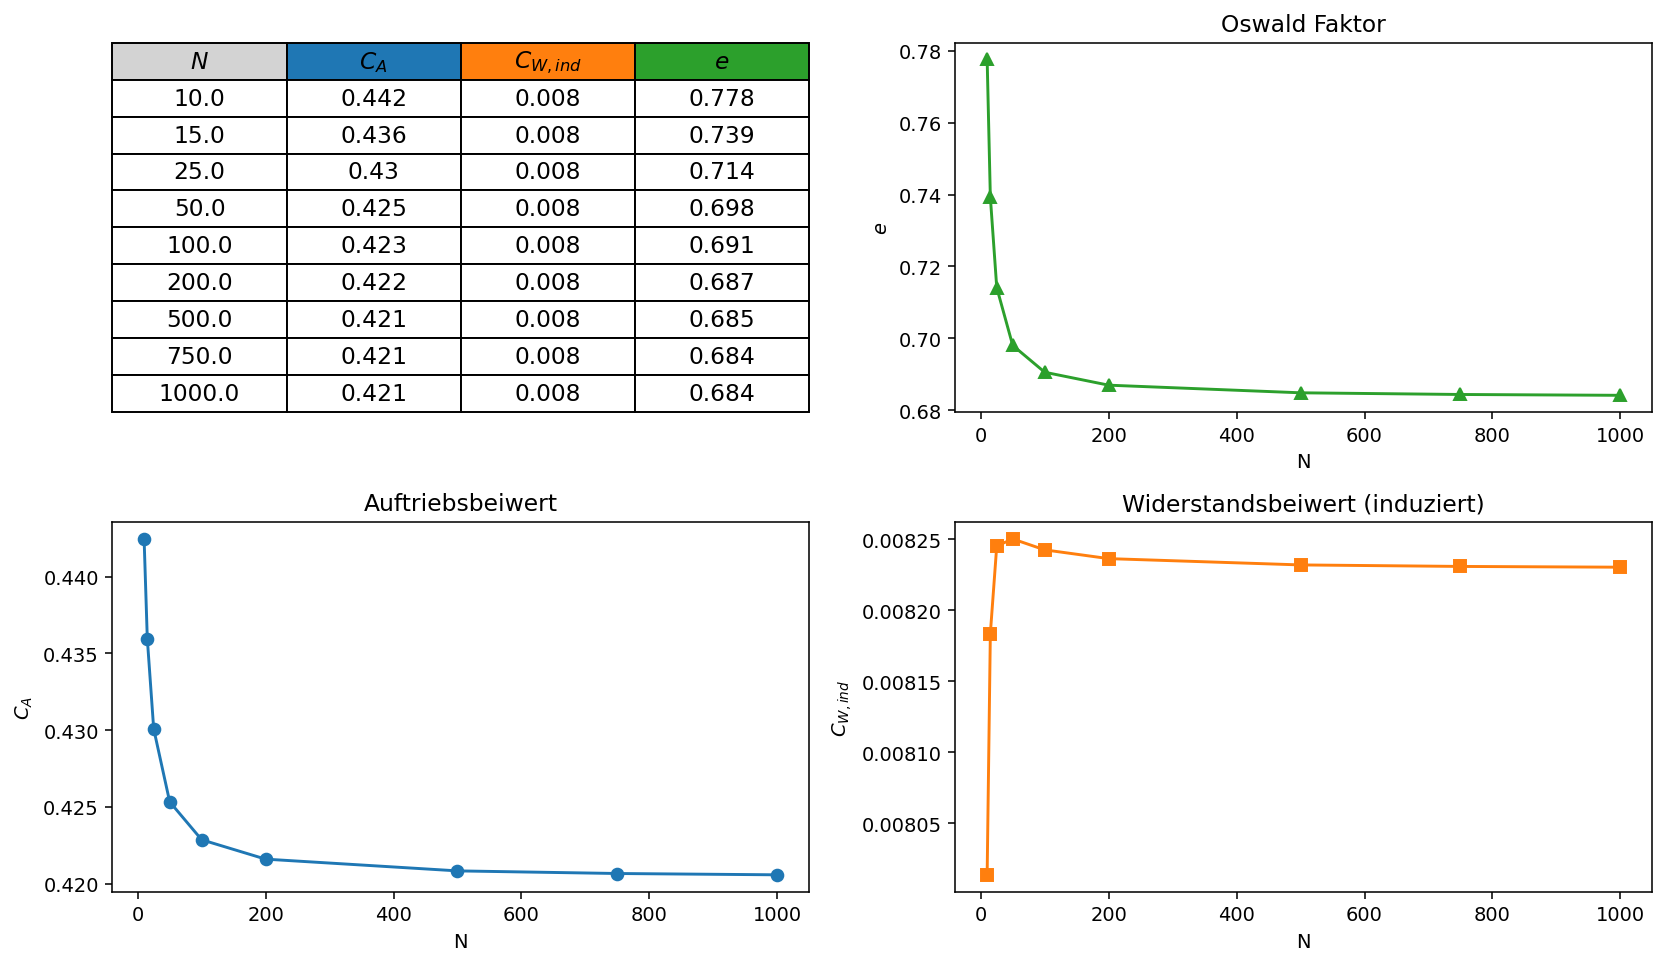

In [244]:
# Erstelle ein DataFrame
data = {
    r'$N$': N_study,
    r'$C_A$': [round(num, 3) for num in C_A],
    r'$C_{W,ind}$': [round(num, 3) for num in C_W_ind],
    r'$e$': [round(num, 3) for num in Oswald]
}
df = pd.DataFrame(data)

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

# Plot für C_A
axs[1][0].plot(N_study, C_A, marker='o', linestyle='-', color='C0')
axs[1][0].set_xlabel(r"N")
axs[1][0].set_ylabel(r'$C_A$')
axs[1][0].set_title("Auftriebsbeiwert")

# Plot für C_W_ind
axs[1][1].plot(N_study, C_W_ind, marker='s', linestyle='-', color='C1')
axs[1][1].set_xlabel(r"N")
axs[1][1].set_ylabel(r'$C_{W,ind}$')
axs[1][1].set_title("Widerstandsbeiwert (induziert)")

# Plot für Oswald
axs[0][1].plot(N_study, Oswald, marker='^', linestyle='-', color='C2')
axs[0][1].set_xlabel(r"N")
axs[0][1].set_ylabel(r'$e$')
axs[0][1].set_title("Oswald Faktor")

# Erstelle die Tabelle
axs[0][0].axis('tight')
axs[0][0].axis('off')
table = axs[0][0].table(cellText=df.values, colLabels=df.columns, colColours=["lightgray", "C0", "C1", "C2"], cellLoc='center', loc='center')

# Increase row height and font size
for key, cell in table.get_celld().items():
    cell.set_height(0.1)
    cell.set_fontsize(12)

plt.tight_layout()
plt.show()

## Aufgabe 1 b) Einfluss der Zuspitzung

Optimieren Sie vier Trapezflügel mit $\Lambda = 3, 7, 10, 20$ und $l_i = 1$ über eine Variation der Flügeltiefe an der Flügelspitze hin zu einer möglichst widerstandsarmen zirkulationsverteilung. Aus der letzten Aufgabe ergab sich das eine Anzahl von 500 Elementarflügeln für eine ausreichende Konvergenz genügt.

#### Iterationsschleife

In [245]:
N = 500
delta_b = b/N

# Initialisieren der benötigten Variablen
AR_study = [3, 7, 10, 20]
l_a_study = [0.0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.23, 0.25, 0.3, 0.35, 0.5, 0.75, 1]
result = {"lambda": l_a_study}

# Iteration über verschiedene AR und l_a
for AR in AR_study:
    oswald = []
    for l_a in l_a_study:

        # Berechnung der Halbspannweite, Fläche und Elementarflügelbreite
        b = (l_i + l_a) * AR / 2
        s = b / 2 
        S = b/2 * (l_a + l_i)  
        delta_b = b/N

        # Berechnen aller Hufeisenwirbel-Koordinaten
        y_a, y_b, y_c, x_a, x_b, x_c, y_aoo, y_boo, x_aoo, x_boo = compute_coords(s, N, delta_b, l_i, l_a) 

        # Berechnen der Anteile der Koeffizientenmatrix
        a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c)
        
        # Berechnen von Koeffizientenmatrizen und Anstellwinkelvektor
        a = a_AB + a_Aoo - a_Boo  
        a_ind = a_Aoo - a_Boo                
        alpha_g = np.full((x_a.size), alpha)   

        # Berechnen der Kräfte
        Gamma = np.linalg.solve(a, alpha_g * (- U_inf))
        A_j = rho * delta_b * U_inf * Gamma
        A = np.sum(A_j)
        w_ind = a_ind @ Gamma
        W_ind = np.sum(-rho *w_ind @ Gamma * delta_b)

        # Berechnen der Beiwerte
        C_A = 2*A / rho / U_inf**2 / S
        C_W_ind = 2*W_ind / rho / U_inf**2 / S
        C_W_ind_ell = C_A**2 / AR / np.pi

        # Berechnen des Oswald-Faktors
        oswald.append(C_W_ind_ell / C_W_ind)
    
    result[str(AR)] = oswald

#### Ergebnisse

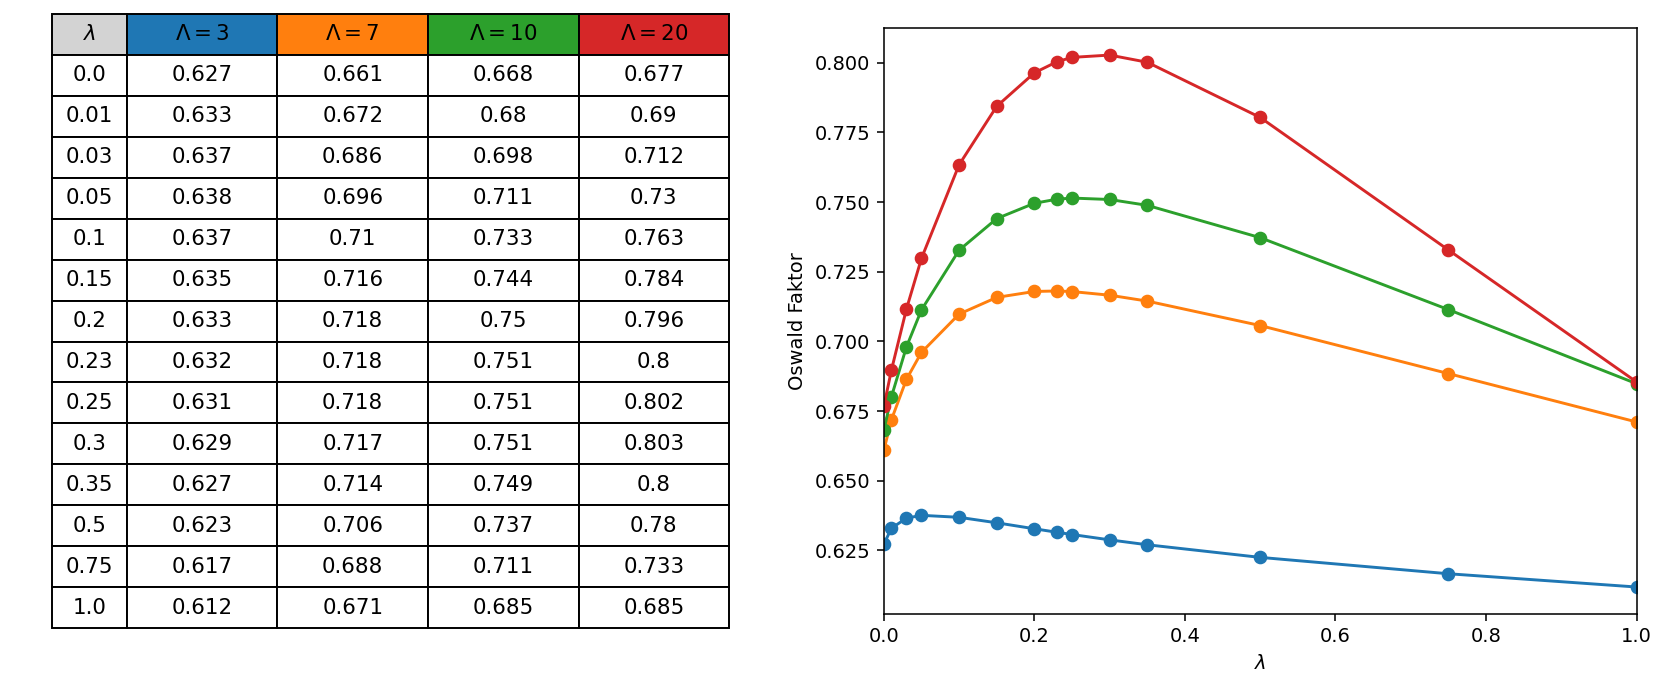

In [246]:
# Ergebnisse plotten
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Erstelle ein DataFrame
df = {
    r'$\lambda$': l_a_study,
    r"$\Lambda = 3$": [round(num, 3) for num in result["3"]],
    r"$\Lambda = 7$": [round(num, 3) for num in result["7"]],
    r"$\Lambda = 10$": [round(num, 3) for num in result["10"]],
    r"$\Lambda = 20$": [round(num, 3) for num in result["20"]]
}
df = pd.DataFrame(df)

for key, val in result.items():
    if key == "lambda":
        pass
    else:
        ax[1].plot(l_a_study, val, "o-", label=r"$\Lambda$ = " + key)

ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel("Oswald Faktor")
ax[1].set_xlim([0, 1])

# Erstellen der Tabelle
columns = [r"$\lambda$", r"$\Lambda = 3$", r"$\Lambda = 7$", r"$\Lambda = 10$", r"$\Lambda = 20$"]

ax[0].axis('tight')
ax[0].axis('off')
table = ax[0].table(cellText=df.values, colLabels=df.columns, colColours=["lightgray", "C0", "C1", "C2", "C3"], 
                    colWidths= [0.1, 0.2, 0.2, 0.2, 0.2], cellLoc='center', loc='center', fontsize=12)

# Increase row height and font size
for key, cell in table.get_celld().items():
    cell.set_height(0.07)
    cell.set_fontsize(12)

plt.tight_layout()
plt.show()